In [50]:
# Python
import pandas as pd
from prophet import Prophet

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Prophet を使う
## 時系列を予測するのではなく、時系列成分を学習データのカラムとして扱う
### y(t) = g(t) + s(t) +h(t) +e(t)
- g(t) : トレンド
- s(t) : 周期性
- h(t) : イベント
- e(t) : ノイズ


In [52]:
data= pd.read_csv("data_raw_Robyn.csv",parse_dates=["DATE"])
data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000


In [53]:
data.columns = [col.lower() if col == "DATE" else col for col in data.columns]
data.head()

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000


In [54]:
holidays = pd.read_csv("holidays_daily.csv",parse_dates=["ds"])
holidays.head()

,ds,holiday,country,year
0,1995-01-01,New Year's Day,AE,1995
1,1995-03-01,Eid al-Fitr,AE,1995
2,1995-03-02,Eid al-Fitr,AE,1995
3,1995-03-03,Eid al-Fitr,AE,1995
4,1995-03-04,Eid al-Fitr,AE,1995


In [55]:
holidays["begin_week"]=holidays["ds"].dt.to_period("W-SUN").dt.start_time


In [56]:
hodidays_weekly = holidays.groupby(["begin_week","country","year"],as_index=False).agg({"holiday":"#".join,"country":"first","year":"first"}).rename(columns={"begin_week":"ds"})

In [57]:
hodidays_weekly

,ds,holiday,country,year
0,1994-12-26,New Year's Day,AE,1995
1,1994-12-26,Ano Nuevo [New Year's Day],AR,1995
2,1994-12-26,Neujahr,AT,1995
3,1994-12-26,New Year's Day,AU,1995
4,1994-12-26,Ana Nobo [New Year's Day],AW,1995
...,...,...,...,...
35854,2044-12-26,Druhy sviatok vianocny,SK,2044
35855,2044-12-26,New Year's Eve,TH,2044
35856,2044-12-26,Boxing Day#Christmas Day (Observed),UK,2044
35857,2044-12-26,Christmas Day (Observed),US,2044


In [58]:
holidays_weekly_de = hodidays_weekly.query("(country=='DE')").copy()
holidays_weekly_de

,ds,holiday,country,year
12,1994-12-26,Neujahr,DE,1995
183,1995-04-10,Karfreitag,DE,1995
222,1995-04-17,Ostermontag,DE,1995
270,1995-05-01,Erster Mai,DE,1995
346,1995-05-22,Christi Himmelfahrt,DE,1995
...,...,...,...,...
35445,2044-05-23,Christi Himmelfahrt,DE,2044
35481,2044-06-06,Pfingstmontag,DE,2044
35646,2044-10-03,Tag der Deutschen Einheit,DE,2044
35781,2044-12-19,Erster Weihnachtstag,DE,2044


In [59]:
prophet_data = data.rename(columns={"revenue":"y","date":"ds"})
prophet_data = pd.concat([prophet_data,pd.get_dummies(data["events"],drop_first=True,prefix="events")],axis=1)
prophet_data.head()

,ds,y,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,events_event2,events_na
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846,False,True
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000,False,True
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000,False,True
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000,False,True
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000,False,True


<Axes: xlabel='ds', ylabel='y'>

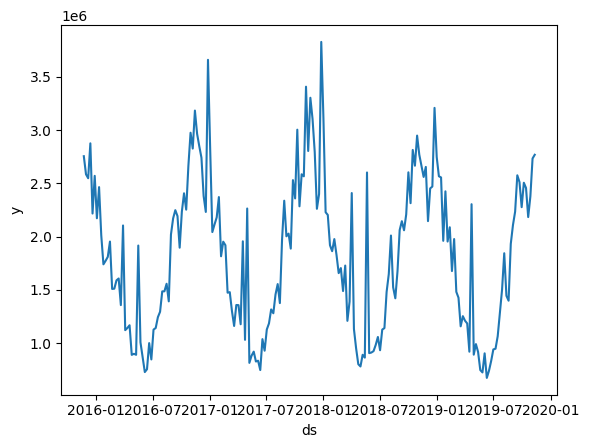

In [60]:
import seaborn as sns

sns.lineplot(prophet_data,x="ds",y="y")

In [61]:
prophet=Prophet(yearly_seasonality=True,weekly_seasonality=True,holidays=holidays_weekly_de)
prophet.add_regressor(name="events_event2")
prophet.add_regressor(name="events_na")

In [63]:
prophet.fit(prophet_data[["ds","y","events_event2","events_na"]])
prophet_predict = prophet.predict(prophet_data[["ds","y","events_event2","events_na"]])

22:43:44 - cmdstanpy - INFO - Chain [1] start processing
22:43:44 - cmdstanpy - INFO - Chain [1] done processing


c:\Users\akimo\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\akimo\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],
c:\Users\akimo\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

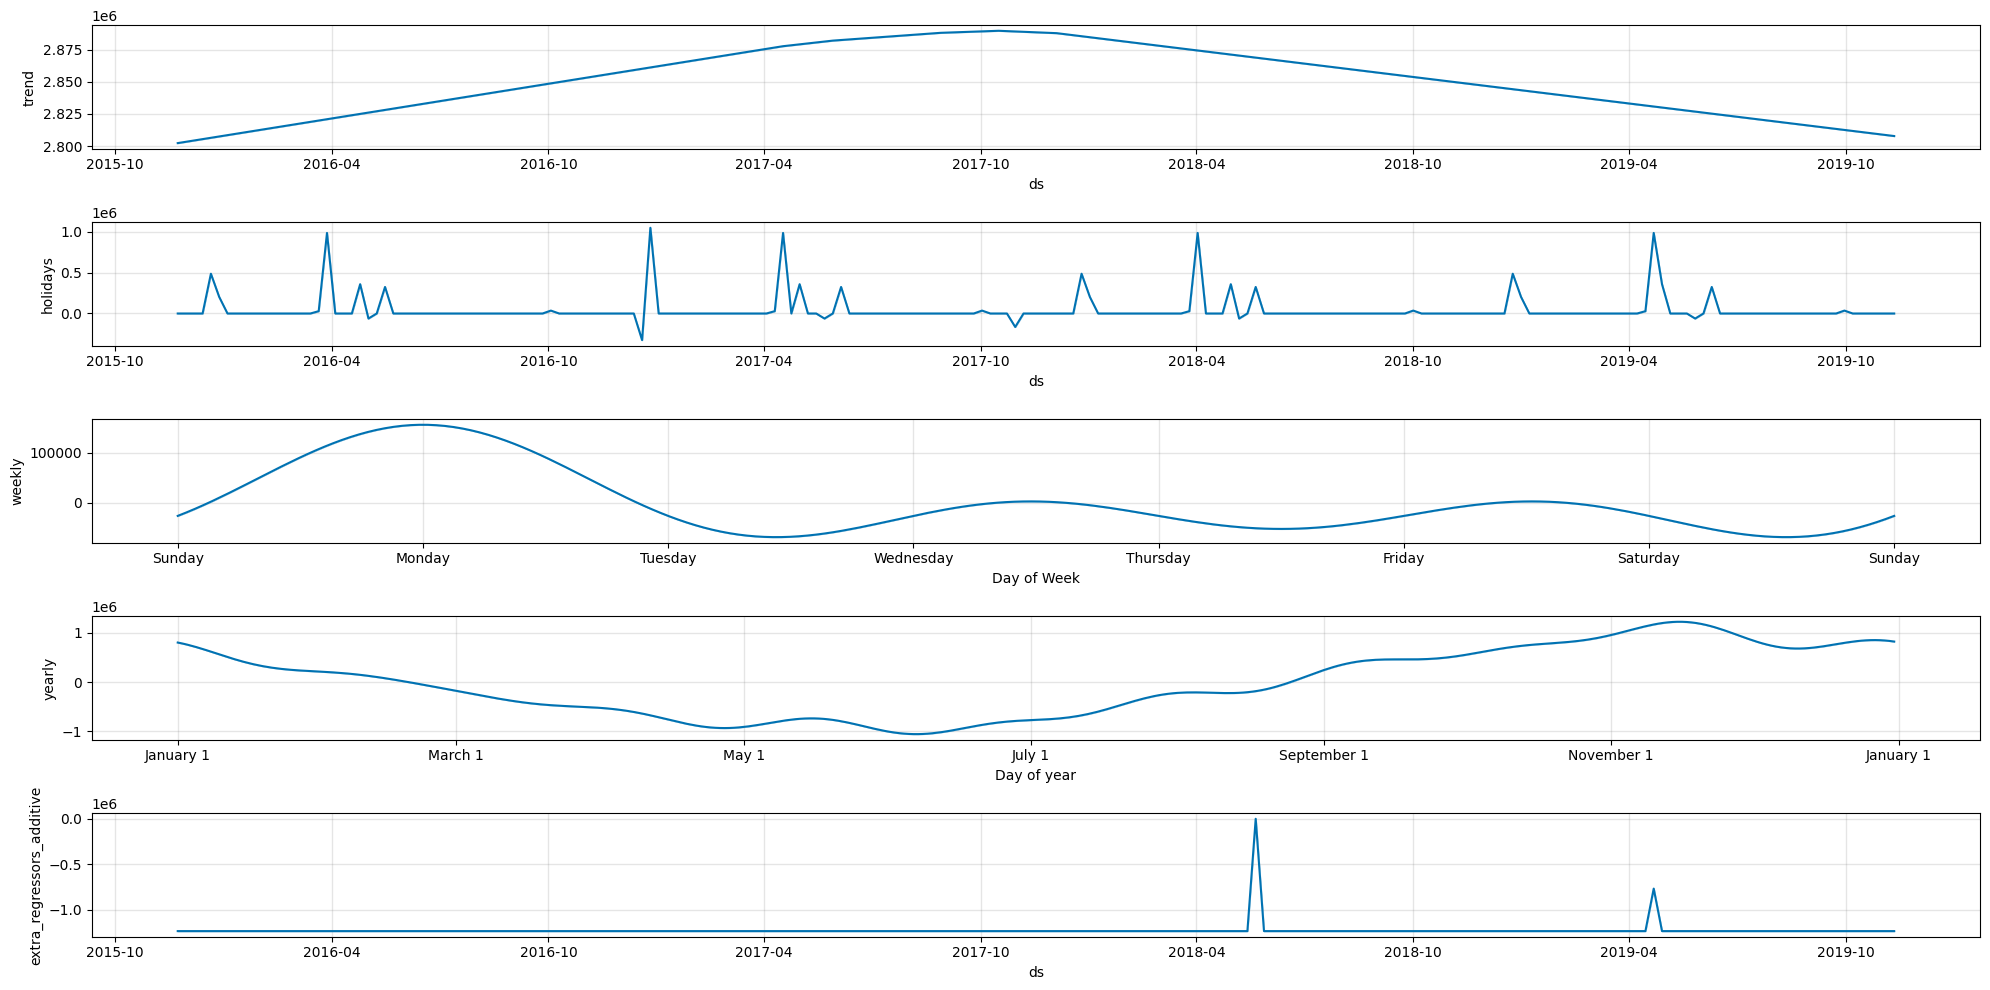

In [65]:
plot = prophet.plot_components(prophet_predict,figsize=(20,10))